# Getting started with Sentinel 2 data

**Background** As of mid-February 2018, Sentinel 2 data is available to access within the a development environment on AWS. There are a number of things that need to be done prior to gaining access to the Sentinel 2 archive. For the purpose of this notebook, we will assume you have successfully gained access to the AWS environment where Sentinel 2 data is currently housed. 

**What does this notebook do?** This notebook steps you through how to load in and plot up data from Sentinel 2. It explores the data that are available from the Sentinel 2 satellite, and briefly describes the Sentinel satellite bands. It then loads in the `s2a_ard_granule` product and plots it up in true and false colour. It uses the provided pixel quality data to filters the example scene based on `clear` pixels. 

**Date**: February 2018.

**Author**: Claire Krause

**Tags**
`Sentinel2`, `products`, `threeBandImage`, `threeBandImage_subplots`, `dc.list_products`, `dc.load`, `query`, `beginner`, `plot`, `image`, `pixelquality`

In [7]:
% pylab notebook
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure

#get the DEA version of the plotting functions
import os
import rasterio
sys.path.append(os.path.abspath('/g/data/r78/cek156/dea-notebooks/algorithms'))
import DEADataHandling

from datacube.storage.storage import write_dataset_to_netcdf

# Replace with the path to your own home directory on the VDI
s2 = Datacube(config='/home/547/rjd547/sentinel2.conf')

Populating the interactive namespace from numpy and matplotlib


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Define some plotting functions for later on

In [8]:
def threeBandImage(ds, bands, time = 0, figsize = [10,10], projection = 'projected'):
    '''
    threeBandImage takes three spectral bands and plots them on the RGB bands of an image. 
    
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    
    Optional:
    time - Index value of the time dimension of ds to be plotted
    figsize - dimensions for the output figure
    projection - options are 'projected' or 'geographic'. To determine if the image is in degrees or northings
    '''
    t, y, x = ds[bands[0]].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(bands):
        rawimg[:,:,i] = ds[colour][time].values
    rawimg[rawimg == -999] = np.nan
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    fig = plt.figure(figsize = figsize)
    imshow(img_toshow)
    ax = plt.gca()
    ax.set_title(str(ds.time[time].values), fontweight = 'bold', fontsize = 16)
    ax.set_xticklabels(ds.x.values)
    ax.set_yticklabels(ds.y.values)
    if projection == 'geographic':
        ax.set_xlabel('Longitude', fontweight = 'bold')
        ax.set_ylabel('Latitude', fontweight = 'bold')
    else:
        ax.set_xlabel('Eastings', fontweight = 'bold')
        ax.set_ylabel('Northings', fontweight = 'bold')

def threeBandImage_subplots(ds, bands, num_cols, figsize = [10,10], projection = 'projected', left  = 0.125, 
                            right = 0.9, bottom = 0.1, top = 0.9, wspace = 0.2, hspace = 0.4):
    '''
    threeBandImage_subplots takes three spectral bands and multiple time steps, and plots them 
    on the RGB bands of an image. 
    
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    num_cols - number of columns for the subplot
    
    Optional:
    figsize - dimensions for the output figure
    projection - options are 'projected' or 'geographic'. To determine if the image is in degrees or northings
    left  = 0.125  # the space on the left side of the subplots of the figure
    right = 0.9    # the space on the right side of the subplots of the figure
    bottom = 0.1   # the space on the bottom of the subplots of the figure
    top = 0.9      # the space on the top of the subplots of the figure
    wspace = 0.2   # the amount of width reserved for blank space between subplots
    hspace = 0.2   # the amount of height reserved for white space between subplots
    '''
    # Find the number of rows/columns we need, based on the number of time steps in ds
    timesteps = ds.time.size
    num_rows = int(ceil(timesteps/num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize = figsize)
    fig.subplots_adjust(left  = left, right = right, bottom = bottom, top = top, wspace = wspace, hspace = hspace)
    numbers = 0
    try:
        for ax in axes.flat:
            t, y, x = ds[bands[0]].shape
            rawimg = np.zeros((y,x,3), dtype = np.float32)
            for i, colour in enumerate(bands):
                rawimg[:,:,i] = ds[colour][numbers].values
            rawimg[rawimg == -999] = np.nan
            img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
            ax.imshow(img_toshow)
            ax.set_title(str(ds.time[numbers].values), fontweight = 'bold', fontsize = 12)
            ax.set_xticklabels(ds.x.values, fontsize = 8, rotation = 20)
            ax.set_yticklabels(ds.y.values, fontsize = 8)
            if projection == 'geographic':
                ax.set_xlabel('Longitude', fontweight = 'bold', fontsize = 10)
                ax.set_ylabel('Latitude', fontweight = 'bold', fontsize = 10)
            else:
                ax.set_xlabel('Eastings', fontweight = 'bold', fontsize = 10)
                ax.set_ylabel('Northings', fontweight = 'bold', fontsize = 10)
            numbers = numbers + 1
    except IndexError:
        # This error will pop up if there are not enough scenes to fill the number of rows x columns, so we can 
        # safely ignore it
        pass    

        
def write_your_netcdf(data, dataset_name, filename, crs):
    '''this function turns an xarray dataarray into a dataset so we can write it to netcdf. It adds on a crs definition
    from the original array. data = your xarray dataset, dataset_name is a string describing your variable. Bex March 2018'''    
    #turn array into dataset so we can write the netcdf
    if isinstance(data,xr.DataArray):
        dataset= data.to_dataset(name=dataset_name)
    elif isinstance(data,xr.Dataset):
        dataset = data
    else:
        print('your data might be the wrong type, it is: '+type(data))
    #grab our crs attributes to write a spatially-referenced netcdf
    dataset.attrs['crs'] = crs
    dataset.attrs['affine'] =affine
    #dataset.dataset_name.attrs['crs'] = crs
    try:
        write_dataset_to_netcdf(dataset, filename)
    except RuntimeError as err:
        print("RuntimeError: {0}".format(err))   
        
def new_dataset_to_geotiff(filename, data):
    '''
    this function uses rasterio and numpy to write a multi-band geotiff for one
    timeslice, or for a single composite image. It assumes the input data is an
    xarray dataset (note, dataset not dataarray) and that you have crs and affine
    objects attached.It will use the correct predictor for either int or float dtypes.
    future users may wish to assert that these assumptions are correct.
    Last modified: April 2018
    Authors: Bex Dunn and Josh Sixsmith
    Modified by: Claire Krause, Robbi Bishop-Taylor, Bex Dunn
    inputs
    filename - string containing filename to write out to
    data - dataset to write out
    Note: this function cuurrently requires the data have lat/lon only, i.e. no
    time dimension
    '''

    kwargs = {'driver': 'GTiff',
              'count': len(data.data_vars),  # geomedian no time dim
              'width': data.sizes['x'], 'height': data.sizes['y'],
              'crs': data.crs.crs_str,
              'transform': data.affine,
              'dtype': list(data.data_vars.values())[0].values.dtype,
              'nodata': 0,
              'compress': 'deflate', 'zlevel': 4, 'predictor': 2}
    # for ints use 2 for floats use 3} ### FIXME how to set the predictor conditionally?

    with rasterio.open(filename, 'w', **kwargs) as src:
        for i, band in enumerate(data.data_vars):
            src.write(data[band].data, i + 1)               
    

# See what Sentinel 2 products are currently available

In [9]:
products = s2.list_products()
display_columns = ['name', 'description', 'instrument', 'platform', 'product_type', 'crs', 'resolution']
sentinel_products = products[products['instrument'] == 'MSI'][display_columns]
sentinel_products

,name,description,instrument,platform,product_type,crs,resolution
id,,,,,,,
44,s2a_ard_granule,Sentinel-2A MSI ARD - NBAR NBART and Pixel Qua...,MSI,Sentinel-2A,S2MSIARD,NaN,NaN
41,s2a_level1c_granule,Sentinel-2A Level1C - Ortho Rectified Top of A...,MSI,Sentinel-2A,S2MSI1C,NaN,NaN
43,s2a_sen2cor_granule,Sentinel-2 Level 2 - Sen2Cor Bottom of Atmosph...,MSI,SENTINEL_2A,S2MSI2Ap,NaN,NaN
45,s2b_ard_granule,Sentinel-2B MSI ARD - NBAR NBART and Pixel Qua...,MSI,Sentinel-2B,S2MSIARD,NaN,NaN
42,s2b_level1c_granule,Sentinel-2B Level1C - Ortho Rectified Top of A...,MSI,Sentinel-2B,S2MSI1C,NaN,NaN


There are two spectral Sentinel satellites currently in DEA; **Sentinel-2A** and **Sentinel-2B**. Sentinel-2A was launched on 23 June 2015 and Sentinel-2B followed on 7 March 2017.

Both of the Sentinel 2 satellites carries an innovative wide swath high-resolution multispectral imager with 13 spectral bands. The mission is based on a constellation of two identical satellites in the same orbit, 180° apart for optimal coverage and data delivery. Together they cover all Earth's land surfaces, large islands, inland and coastal waters every five days at the equator.

For more information on the Sentinel 2 platforms and applications, check out the [European Space Agency website](http://www.esa.int/Our_Activities/Observing_the_Earth/Copernicus/Sentinel-2). 

# Now we want to actually load and look at some data

We will focus on data from the Sentinel-2a platform for this demonstration, as there is more data available than 2b. To explore the spectral datasets from Sentinel-2a, we will use the `s2a_ard_granule` product. Sometimes multiple scenes are acquired by the satellite on the same day. We want to group these together, and will use `group_by='solar_day'` to do this.

To load in the Sentinel data, we have a number of options we can use in building our data extraction query:

* `lat`/`lon` - specify a bounding box for the extraction. Note that a polygon can be used instead. See [here](https://datacube-core.readthedocs.io/en/stable/dev/generate/datacube.api.query.Query.html#datacube.api.query.Query) for more details
* `output_crs` - the output coordinate reference system to project the data into. The CRS you request will impact on the format for the `resolution` query. Two handy CRSs are 'EPSG:3577', which is the Australian Albers projected coordinate system, and 'EPSG:4325', which is WGS84 a global geographic coordinate system.
* `resolution` - the requested output resolution for the data. If you have selected a geographic coordinate system for the `output_crs`, this will be in degrees. If you have selected a projected coordinate system, this will be in metres. 
* `time` - the time range for the query.

In [10]:
query = {
        'lat': (-19.50, -20.00),
        'lon': (145.05, 145.20),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time':('2017-09-01', '2018-10-01')
}

In [11]:
TheBrook = s2.load(product='s2a_ard_granule', group_by='solar_day', **query)

# Plot this scene up as true colour image

True colour images approximate what the human eye sees when looking at a landscape. Note that the function used for this true colour plot enhances the contrast between the bands, resulting in a colour-enhanced image.

<IPython.core.display.Javascript object>


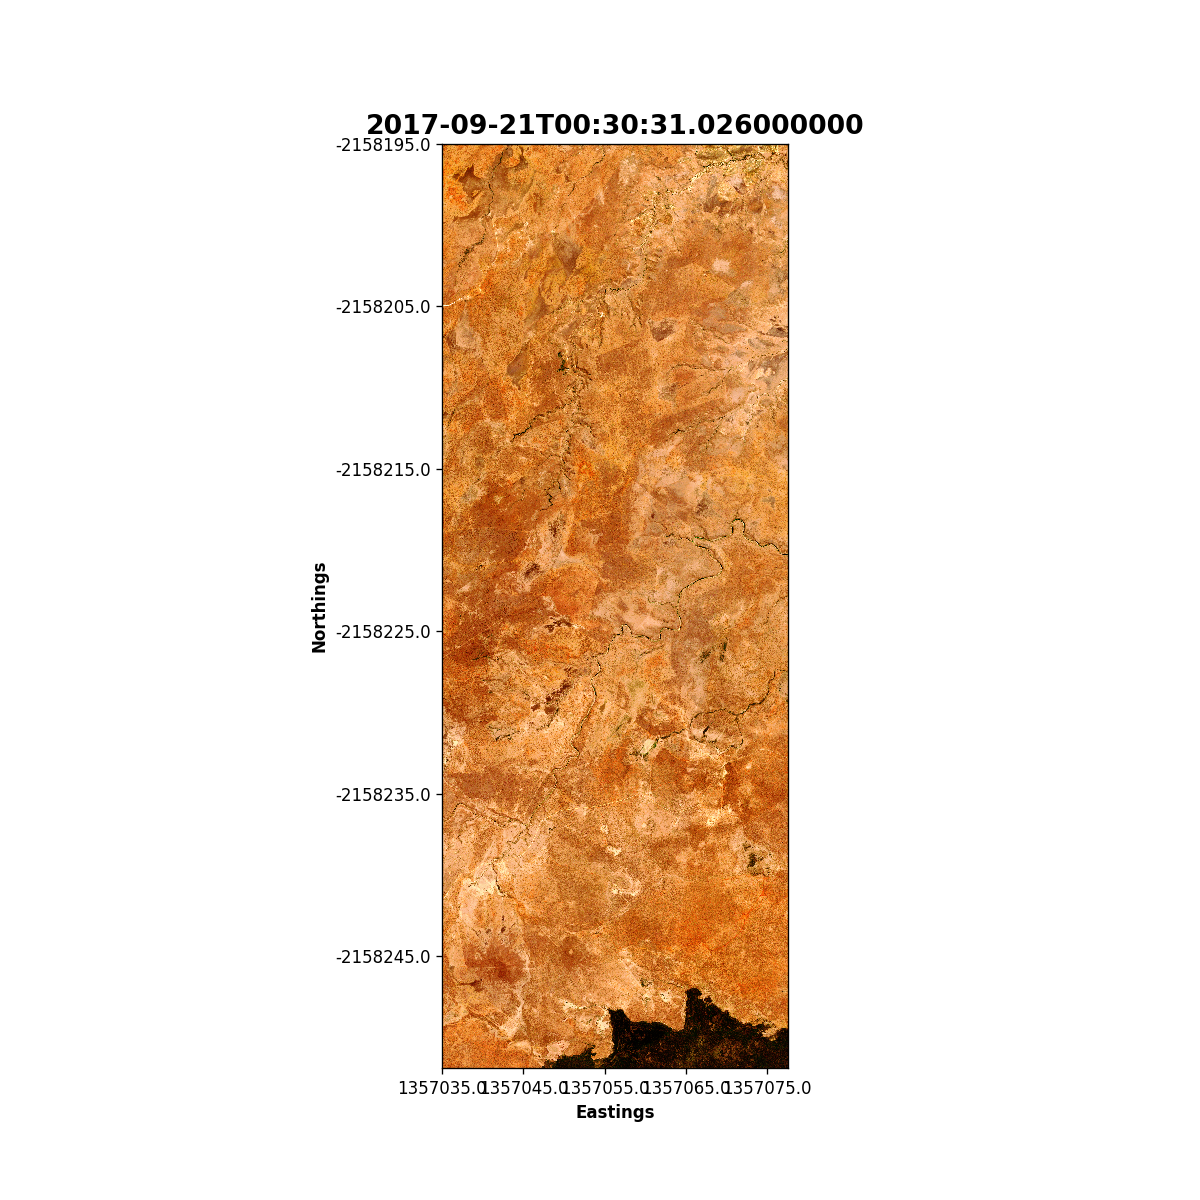

In [17]:
#plt.clf()

threeBandImage(TheBrook, bands = ['red', 'green', 'blue'], time = 3)

In [19]:
save_to = '/g/data/r78/rjd547/groundwater_activities/Images/UpperBurdekin18/S2_fieldwork/'

In [ ]:
#DEADataHandling.dataset_to_geotiff(save_to+'TheBrook_S2_3.tif', TheBrook[['red','green','blue']].isel(time=5))

In [21]:
new_dataset_to_geotiff(save_to+'TheBrook_S2_3.tif', TheBrook[['red','green','blue']].isel(time=3))